To further prepare the data, we will conduct the following tasks:
1. Categorical encoding
4. Outlier Engineering
2. Variable Transformation
3. Discretisation/ Binning
5. Feature Scaling

In [2]:
# load relevant libraries
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score


# load the dataset
df= pd.read_csv('Sephora Dataset Preprocessed')


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df,  # predictors
    df['number_of_loves'],  # target
    test_size=0.3,
    random_state=0)

In [4]:
X_train.shape, X_test.shape

((1892, 25), (811, 25))

In [5]:
y_test=pd.DataFrame(y_test)
y_train=pd.DataFrame(y_train)


In [6]:
numerical_cols=[]
for variables in X_train.columns:
    if X_train[variables].dtype=='int64' or X_train[variables].dtype=='float64':
        numerical_cols.append(variables)
numerical_cols.remove('number_of_loves')
numerical_cols


['number_of_reviews',
 'price',
 'five_star',
 'four_star',
 'three_star',
 'two_star',
 'one_star']

In [7]:
categorical_cols=[]
for variables in X_train.columns:
    if X_train[variables].dtype=='object':
        categorical_cols.append(variables)
        
categorical_cols


['brand_name', 'product_type_1', 'product_type_2']

### 6. Categorical Encoding

In [9]:
df[categorical_cols].nunique()

brand_name        163
product_type_1     20
product_type_2     64
dtype: int64

In [972]:
def find_category_mappings(df, variable, target):
    # grouping dataframe by variables, and get the mean of their target
    # place the average into a list
    return df.groupby([variable])[target].mean().to_dict()


def integer_encode(df, variable, ordinal_mapping):
    # map each variable to their mean target
    df[variable] = df[variable].map(ordinal_mapping)

In [973]:
for variable in categorical_cols:
    mappings = find_category_mappings(X_train, variable, 'number_of_loves')
    integer_encode(X_train, variable, mappings)
    integer_encode(X_test, variable, mappings)

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [974]:
# for values that didn't appear in the training set
# set as 0

X_test['brand_name'].fillna(0, inplace=True)
X_test['product_type_2'].fillna(0, inplace=True)


/Users/audreytang/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [975]:
X_train.isnull().sum()

brand_name                           0
product_type_1                       0
product_type_2                       0
number_of_reviews                    0
number_of_loves                      0
price                                0
skin_type_normal                     0
skin_type_dry                        0
skin_type_combination                0
skin_type_oily                       0
skin_type_sensitive                  0
skin_concerns_fine_lines_wrinkles    0
skin_concerns_pores                  0
skin_concerns_dark_spots             0
skin_concerns_firmness_elasticity    0
skin_concerns_dullness_uneven        0
skin_concerns_dryness                0
skin_concerns_oiliness               0
skin_concerns_puffiness              0
skin_concerns_redness_irritation     0
five_star                            0
four_star                            0
three_star                           0
two_star                             0
one_star                             0
dtype: int64

### 6. Outliers Engineering

As machine learning models can be sensitive to outliers, we will pre-process outliers to ensure the algorithm's performance is not bogged down by them.  We will be capping with inter-quantile range here to demonstrate how to deal with outliers.

In [976]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title(variable+' Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(' quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(variable+' Boxplot')

    plt.show()


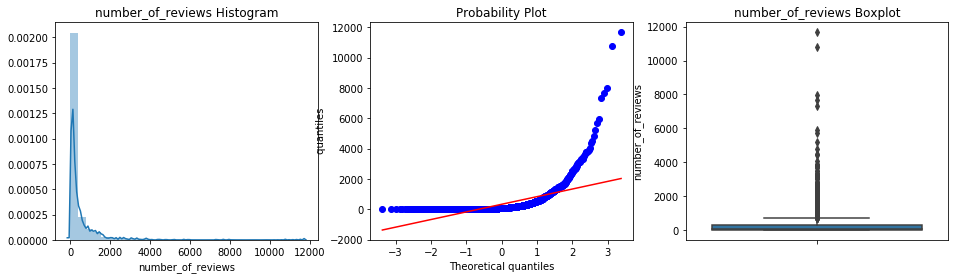

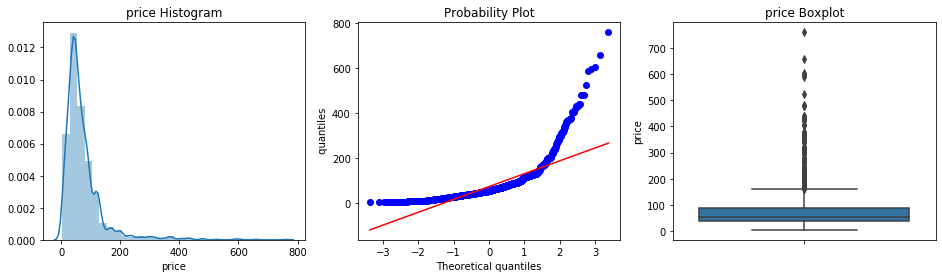

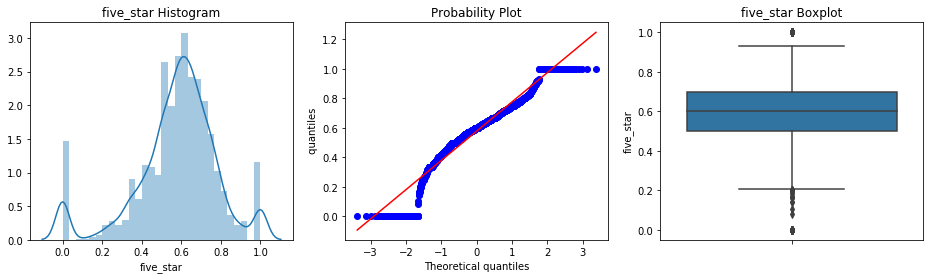

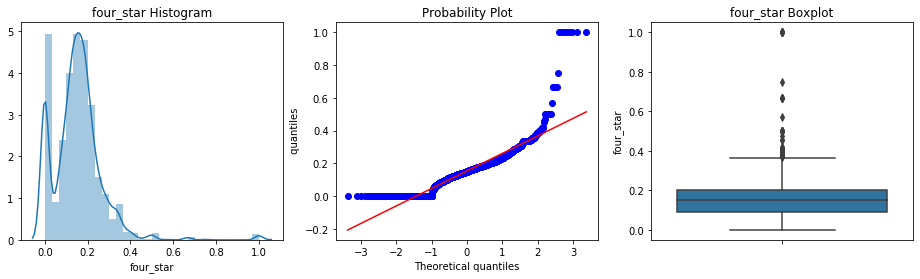

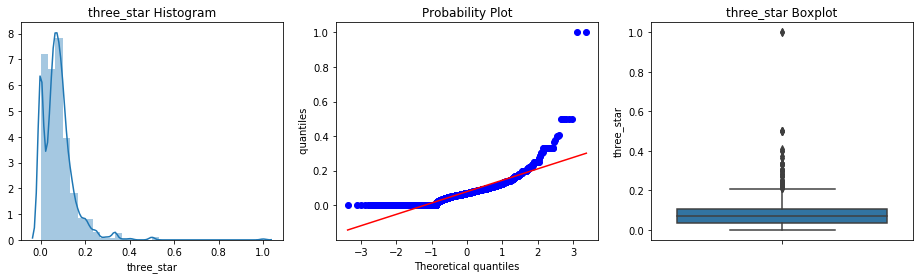

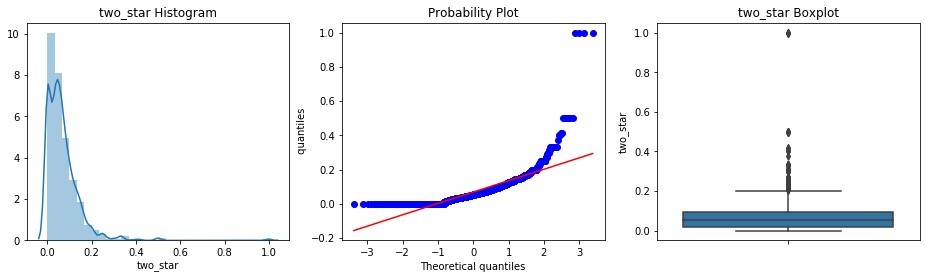

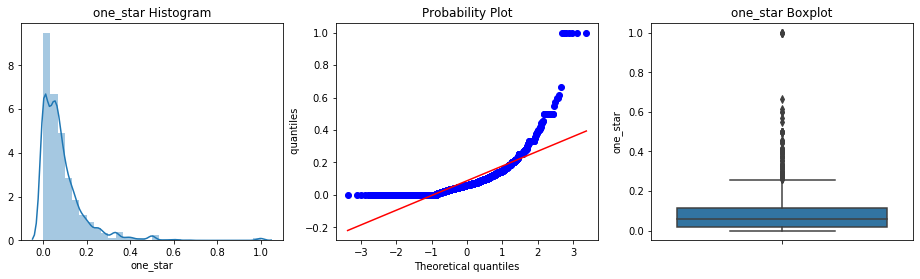

In [977]:
for numerical_column in numerical_cols:
    diagnostic_plots(X_train, numerical_column)

In [978]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary


In [979]:
X_train_trimmed=X_train.copy()
for numerical_column in numerical_cols:
    upper_limit, lower_limit = find_skewed_boundaries(X_train, numerical_column, 1.5)
    
    X_train_trimmed[numerical_column]= np.where(X_train[numerical_column] > upper_limit, upper_limit,
                           np.where(X_train[numerical_column]  < lower_limit, lower_limit, X_train[numerical_column] ))


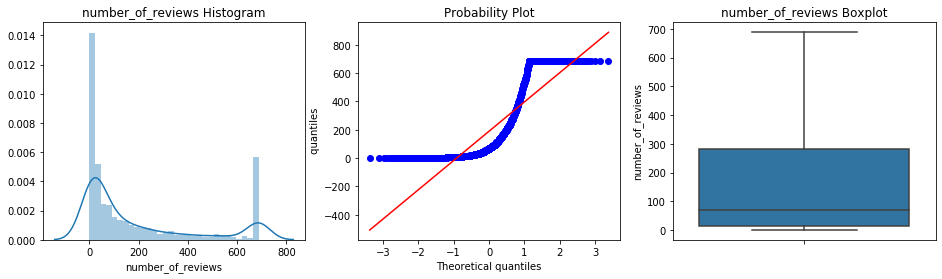

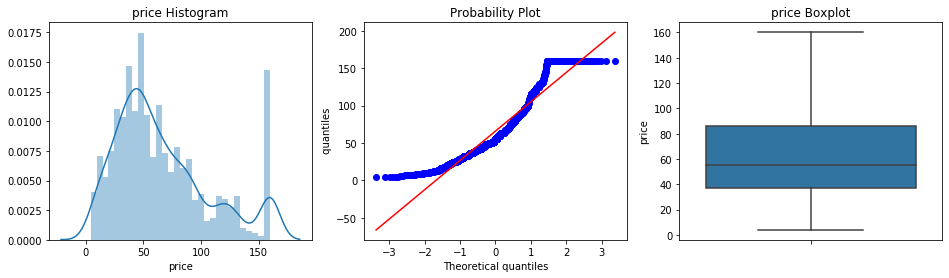

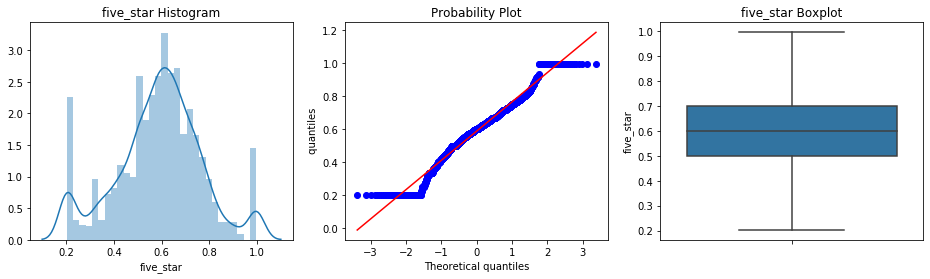

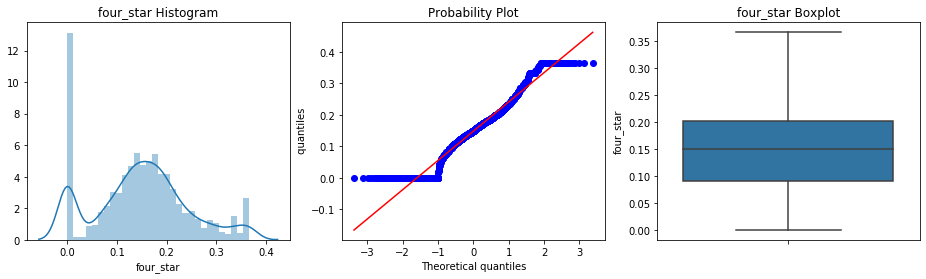

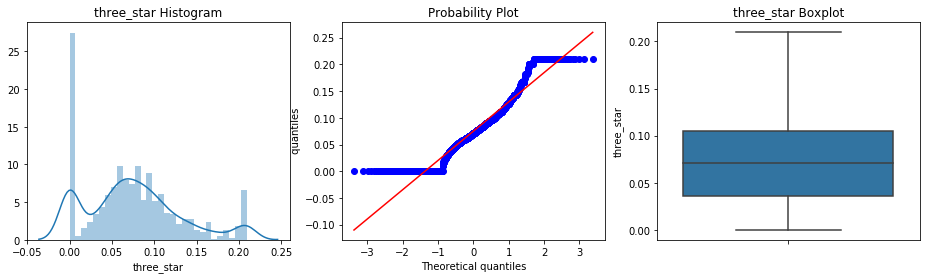

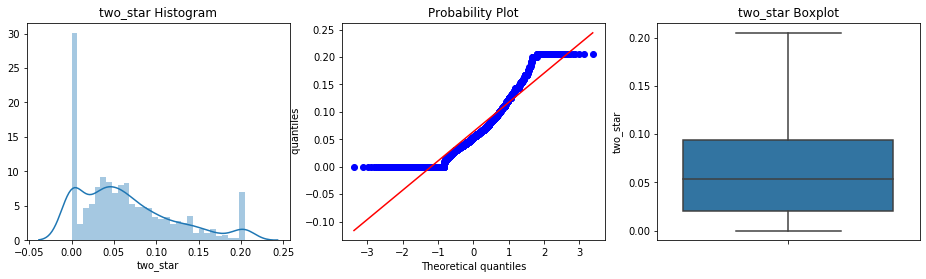

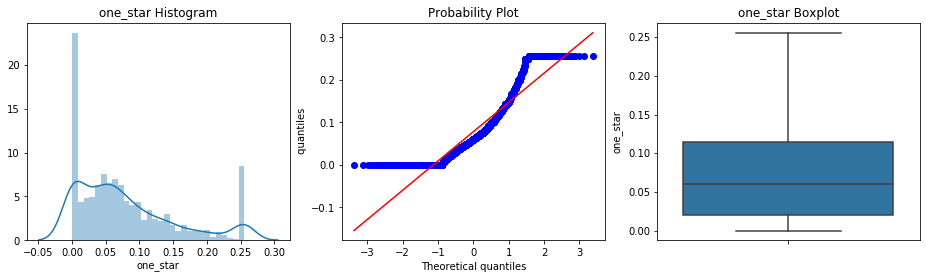

In [980]:
for numerical_column in numerical_cols:
    diagnostic_plots(X_train_trimmed, numerical_column)

As we can see from the above graphs, although outliers have been removed, the dataset has been distorted.  We will be looking at another method later on handling outliers called discretisation.

### 7. Variable Transformation

In [981]:
def diagnostic_plots(df, variable, name):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.title(variable+name+' Histogram')

    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

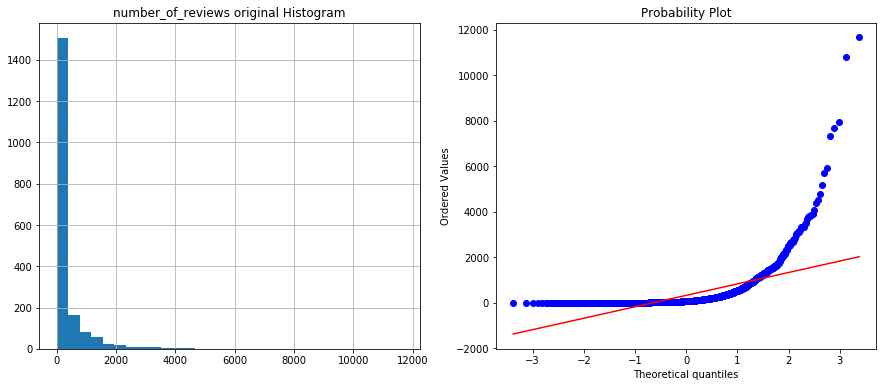

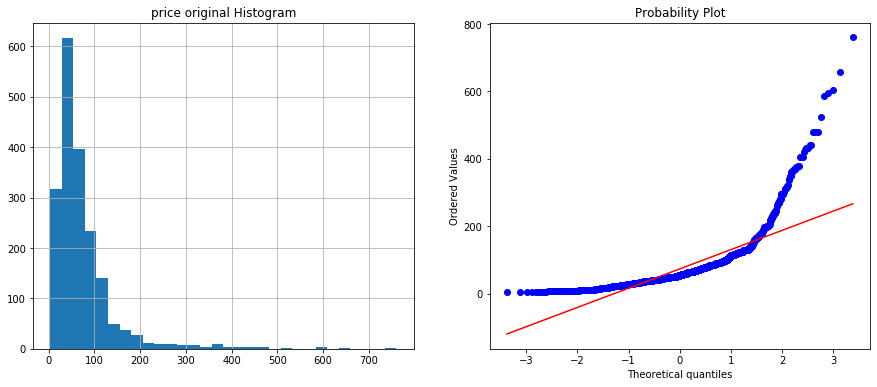

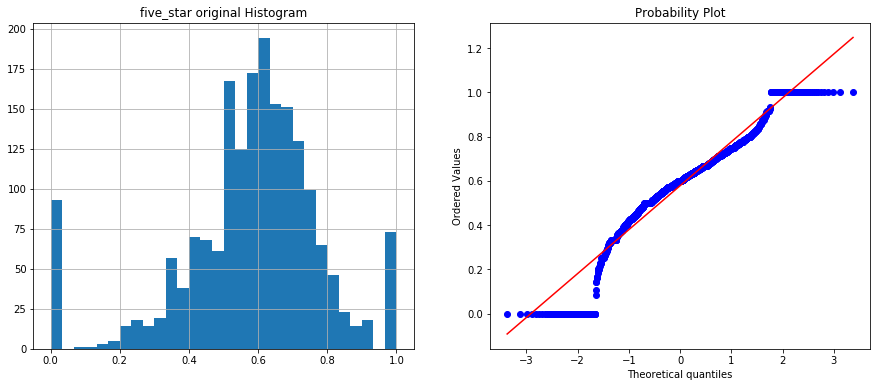

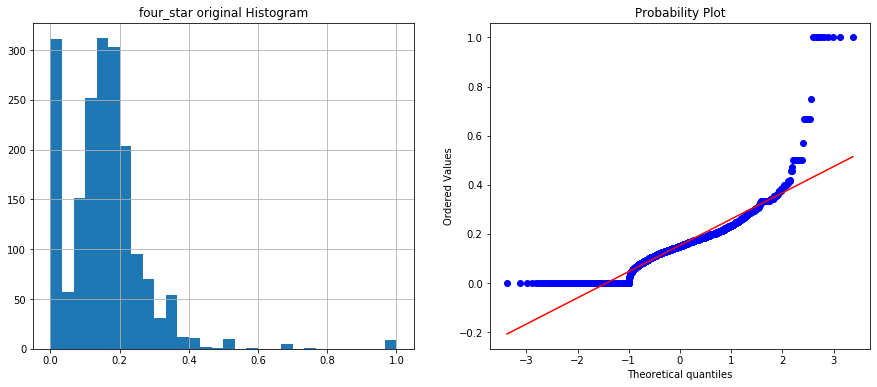

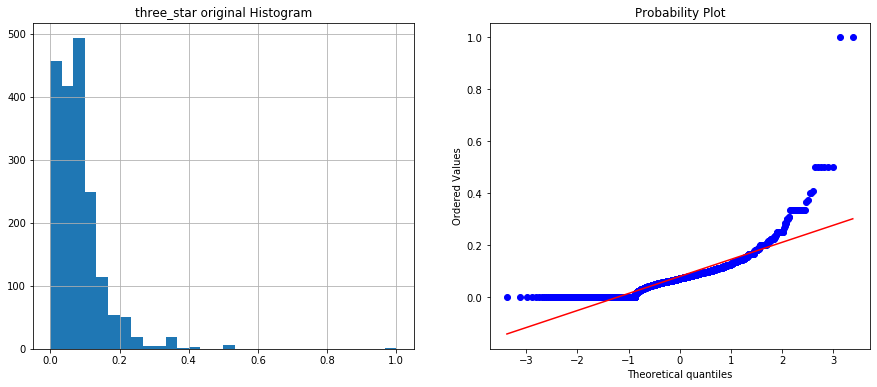

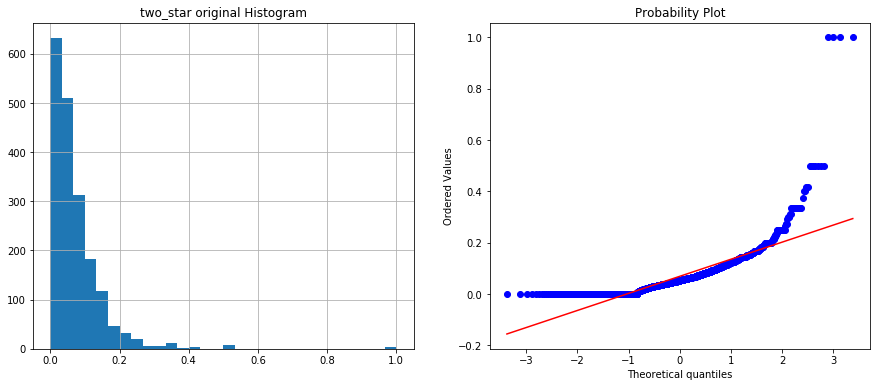

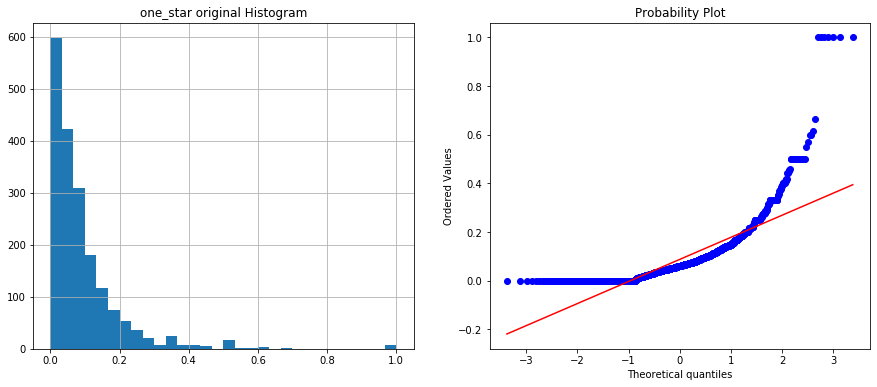

In [982]:
for numerical_column in numerical_cols:
    diagnostic_plots(X_train, numerical_column, ' original')

We notice that some of the columns contain 0, which we cannot use log, reciprocal and box-cox to transform.  In order to allow these values to transform whilst maintaining the 0 values, we will add a zero_indicator in relevant rows, and impute the original column with random value in range.

In [983]:
# numerical_cols_w_zero=['number_of_reviews','five_star', 'four_star', 'three_star', 'two_star', 'one_star']


In [984]:
# for col in numerical_cols_w_zero:
#     # training set
#     X_train[col].replace(0, np.nan, inplace=True)
#     X_train[col+'_zero']=X_train[col].copy()

#     random_sample_train = X_train[col].dropna().sample(
#         X_train[col].isnull().sum(), random_state=0)

#     random_sample_train.index = X_train[X_train[col].isnull()].index

#     X_train[col+'_zero'] = np.where(X_train[col].isnull(), True, False)
#     X_train.loc[X_train[col].isnull(), col] = random_sample_train
    
#     # testing set
#     X_test[col].replace(0, np.nan, inplace=True)
#     X_test[col+'_zero']=X_test[col].copy()

#     random_sample_test = X_test[col].dropna().sample(
#         X_test[col].isnull().sum(), random_state=0)

#     random_sample_test.index = X_test[X_test[col].isnull()].index

#     X_test[col+'_zero'] = np.where(X_test[col].isnull(), True, False)
#     X_test.loc[X_test[col].isnull(), col] = random_sample_test


Upon putting in model, we realized that the result is actually better without the above transformation, so we discard this proposal.  

In [985]:
X_train.head()

,brand_name,product_type_1,product_type_2,number_of_reviews,number_of_loves,price,skin_type_normal,skin_type_dry,skin_type_combination,skin_type_oily,...,skin_concerns_dullness_uneven,skin_concerns_dryness,skin_concerns_oiliness,skin_concerns_puffiness,skin_concerns_redness_irritation,five_star,four_star,three_star,two_star,one_star
2442,15765.400000,13341.114943,11581.813218,12,1940.0,75.0,True,True,True,False,...,True,False,False,False,True,0.500000,0.083333,0.000000,0.416667,0.000000
2032,67.666667,11693.212329,10627.287879,2,93.0,60.0,True,True,True,True,...,False,False,False,True,True,0.500000,0.000000,0.500000,0.000000,0.000000
2326,6061.333333,9950.109091,9642.562500,68,21213.0,249.0,True,True,True,True,...,True,False,False,False,True,0.661765,0.044118,0.073529,0.058824,0.161765
413,16299.744186,13341.114943,11581.813218,40,1922.0,86.0,False,True,True,True,...,False,False,False,False,False,0.450000,0.225000,0.125000,0.025000,0.175000
831,59004.375000,19163.424138,22571.676471,250,38985.0,70.0,False,False,True,True,...,True,False,False,False,False,0.800000,0.100000,0.036000,0.040000,0.024000


In [986]:
def log_transformer(df, column):
    # create a log transformer
    transformer = FunctionTransformer(np.log, validate=True)
    data_t = transformer.transform(df[column].values.reshape(-1, 1))
    data_t = pd.DataFrame(data_t, columns = [column])
    diagnostic_plots(data_t, column, ' log transfomer ')


In [987]:
def reciprocal_transformer(df, column):
    # create a reciprocal transformer
    transformer = FunctionTransformer(lambda x: 1/x, validate=True)
    data_t = transformer.transform(df[column].values.reshape(-1, 1))
    data_t = pd.DataFrame(data_t, columns = [column])
    diagnostic_plots(data_t, column, ' reciprocal transfomer ')


In [988]:
def sqrt_transformer(df, column):
    # create a sqrt transformer
    transformer = FunctionTransformer(lambda x: x**(1/2), validate=True)
    data_t = transformer.transform(df[column].values.reshape(-1, 1))
    data_t = pd.DataFrame(data_t, columns = [column])
    diagnostic_plots(data_t, column, ' sqrt transfomer ')


In [989]:
def exp_transformer(df, column):
    # create an exponential transformer
    transformer = FunctionTransformer(lambda x: x**(1/1.2), validate=True)
    data_t = transformer.transform(df[column].values.reshape(-1, 1))
    data_t = pd.DataFrame(data_t, columns = [column])
    diagnostic_plots(data_t, column, ' exponential transfomer ')


In [990]:
def box_cox_transformer(df, column):
    # create a box-cox transformer
    transformer = PowerTransformer(method='box-cox', standardize=False)
    # find the optimal lambda using the train set
    transformer.fit(df[column].values.reshape(-1, 1))
    data_t = transformer.transform(df[column].values.reshape(-1, 1))
    data_t = pd.DataFrame(data_t, columns = [column])
    diagnostic_plots(data_t, column, ' box-cox transfomer ')


In [991]:
def yeo_johnson_transformer(df, column):
    # create a yeo-johnson
    transformer = PowerTransformer(method='yeo-johnson', standardize=False)
    # learn the lambda from the train set
    transformer.fit(df[column].values.reshape(-1, 1))
    data_t = transformer.transform(df[column].values.reshape(-1, 1))
    data_t = pd.DataFrame(data_t, columns = [column])
    diagnostic_plots(data_t, column, ' yeo-johnson transfomer ')


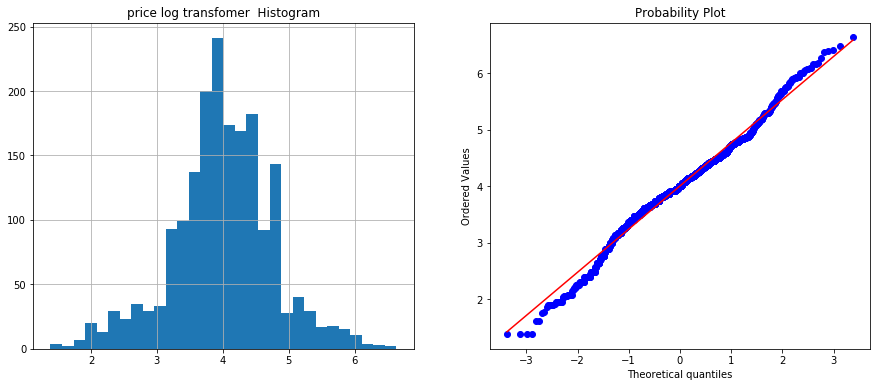

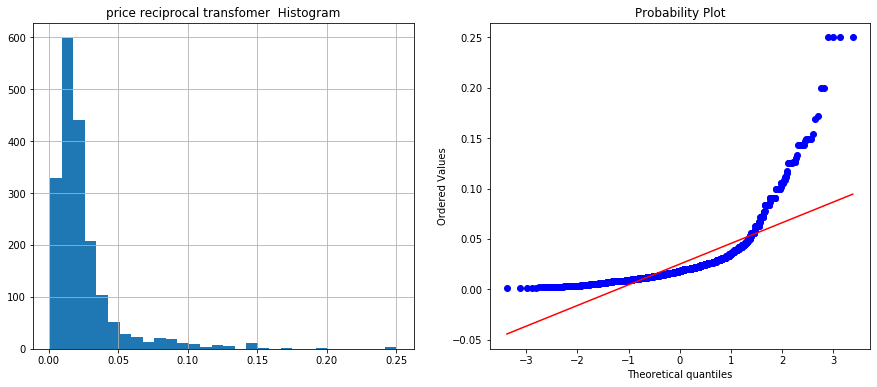

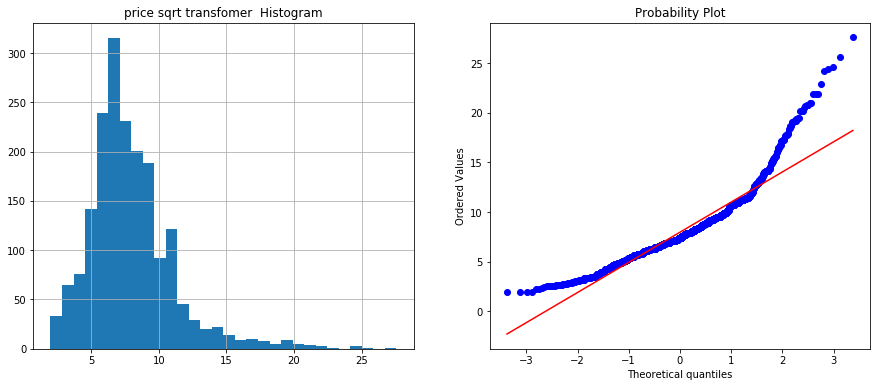

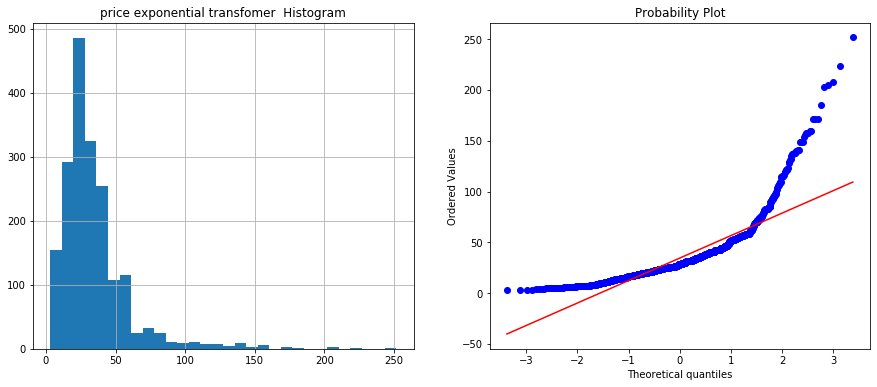

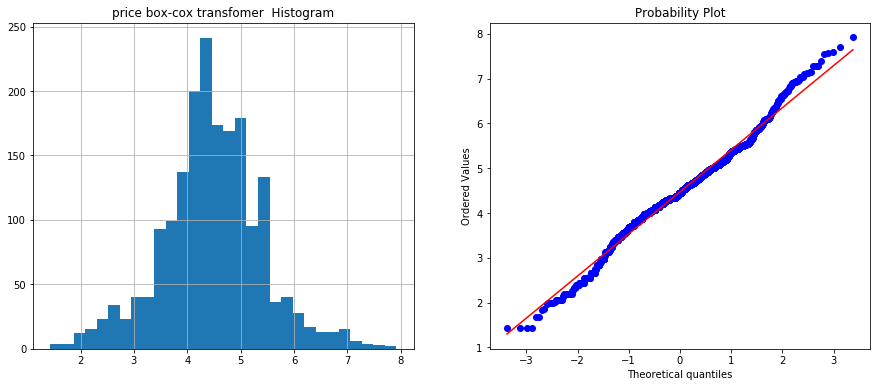

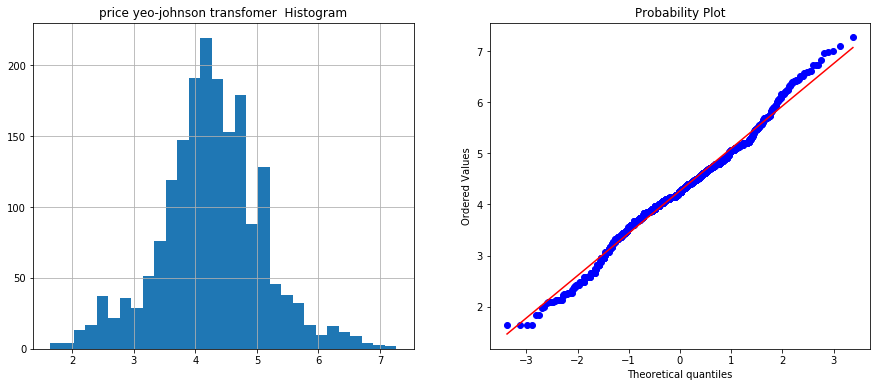

In [992]:
log_transformer(X_train,'price')
reciprocal_transformer(X_train,'price')
sqrt_transformer(X_train,'price')
exp_transformer(X_train,'price')
box_cox_transformer(X_train,'price')
yeo_johnson_transformer(X_train,'price')
    

From the above, we notice that the optimal transformation for price is log transformation

In [993]:
def log_transformer_2(df, column):
    # create a log transformer
    transformer = FunctionTransformer(np.log, validate=True)
    df[column] = transformer.transform(df[column].values.reshape(-1, 1))
    diagnostic_plots(df, column, ' log transfomer ')

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


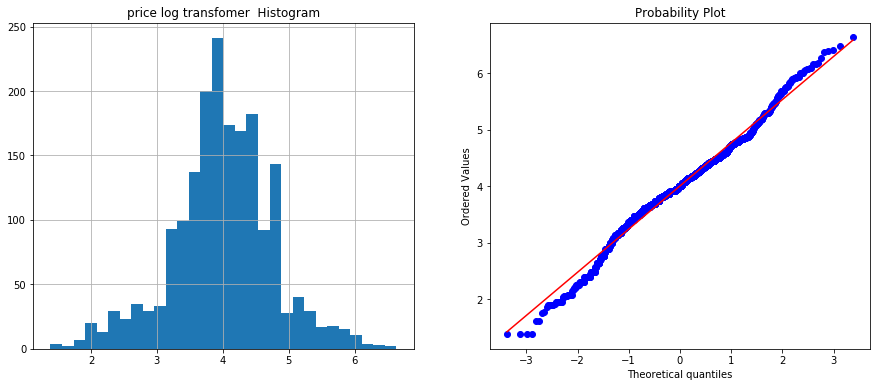

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


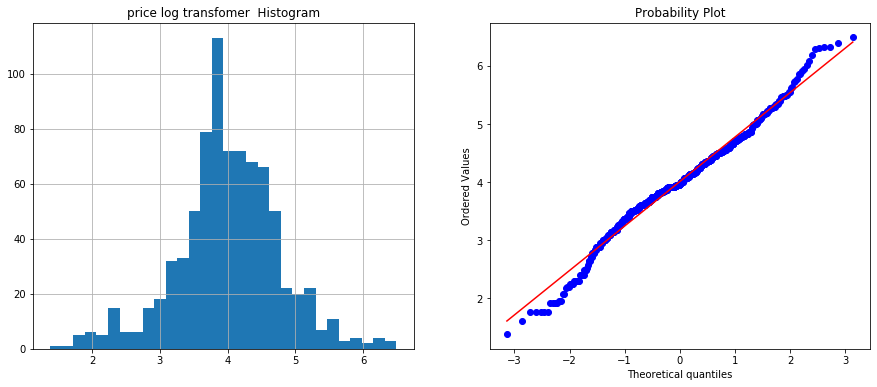

In [994]:
log_transformer_2(X_train, 'price')
log_transformer_2(X_test, 'price')
    

### 9. Discretisation

There are different ways of binning.  We will compare 3 methods: equal width discretisation, equal frequency discretisation and discretisation with decision trees. Upon implementation, we discovered that our dataset performed better without discretisation, so we skip this part.  

In [995]:
# # Equal width discretisation
# for numerical_column in numerical_cols:
#     numerical_range=X_train[numerical_column].max() - X_train[numerical_column].min()
#     min_value = int(np.floor( X_train[numerical_column].min()))
#     max_value = int(np.ceil( X_train[numerical_column].max()))
#     inter_value = int(np.round(numerical_range / 10))
#     if inter_value==0:
#         inter_value=1
#     intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]
#     labels = ['Bin_' + str(i) for i in range(1, len(intervals))]
    
#     X_train[numerical_column+'_ew_disc_labels'] = pd.cut(x=X_train[numerical_column],
#                                     bins=intervals,
#                                     labels=labels,
#                                     include_lowest=True)

#     # and one with bin boundaries
#     X_train[numerical_column+'_ew_disc'] = pd.cut(x=X_train[numerical_column],
#                                  bins=intervals,
#                                  include_lowest=True)


In [996]:
# X_train.head(10)

In [997]:
# for numerical_column in numerical_cols:
#     plt.figure(figsize=(6,4))
#     fig=X_train.groupby(numerical_column+'_disc')[numerical_column].count().plot.bar()
#     plt.xticks(rotation=45)
#     plt.ylabel('Number of observations per bin')
#     plt.title(numerical_column)


In [998]:
# # Equal frequency discretisation

# from sklearn.preprocessing import KBinsDiscretizer



In [999]:
X_train.head()

,brand_name,product_type_1,product_type_2,number_of_reviews,number_of_loves,price,skin_type_normal,skin_type_dry,skin_type_combination,skin_type_oily,...,skin_concerns_dullness_uneven,skin_concerns_dryness,skin_concerns_oiliness,skin_concerns_puffiness,skin_concerns_redness_irritation,five_star,four_star,three_star,two_star,one_star
2442,15765.400000,13341.114943,11581.813218,12,1940.0,4.317488,True,True,True,False,...,True,False,False,False,True,0.500000,0.083333,0.000000,0.416667,0.000000
2032,67.666667,11693.212329,10627.287879,2,93.0,4.094345,True,True,True,True,...,False,False,False,True,True,0.500000,0.000000,0.500000,0.000000,0.000000
2326,6061.333333,9950.109091,9642.562500,68,21213.0,5.517453,True,True,True,True,...,True,False,False,False,True,0.661765,0.044118,0.073529,0.058824,0.161765
413,16299.744186,13341.114943,11581.813218,40,1922.0,4.454347,False,True,True,True,...,False,False,False,False,False,0.450000,0.225000,0.125000,0.025000,0.175000
831,59004.375000,19163.424138,22571.676471,250,38985.0,4.248495,False,False,True,True,...,True,False,False,False,False,0.800000,0.100000,0.036000,0.040000,0.024000


In [1000]:
# labels = ['Q'+str(i) for i in range(1,10)]


In [1001]:
# labels = ['Q'+str(i) for i in range(1,11)]
# numerical_column_1=['number_of_reviews','price','five_star']
# for numerical_column in numerical_column_1:
#     print(numerical_column)
#     X_train[numerical_column], intervals=pd.qcut(
#         X_train[numerical_column], 
#         10, 
#         labels=labels, 
#         retbins=True,
#         duplicates='drop',
#         precision=3)
#     X_test[numerical_column] = pd.cut(x = X_test[numerical_column], labels=labels, bins=intervals)

# labels = ['Q'+str(i) for i in range(1,10)]
# numerical_column_2=['four_star',
#                      'three_star',
#                      'one_star']
# for numerical_column in numerical_column_2:
#     print(numerical_column)
#     X_train[numerical_column], intervals=pd.qcut(
#         X_train[numerical_column], 
#         10, 
#         labels=labels, 
#         retbins=True,
#         duplicates='drop',
#         precision=3)
#     X_test[numerical_column] = pd.cut(x = X_test[numerical_column], labels=labels, bins=intervals)

# labels = ['Q'+str(i) for i in range(1,9)]
# numerical_column_3=['two_star']
# for numerical_column in numerical_column_3:
#     print(numerical_column)
#     X_train[numerical_column], intervals=pd.qcut(
#         X_train[numerical_column], 
#         10, 
#         labels=labels, 
#         retbins=True,
#         duplicates='drop',
#         precision=3)
#     X_test[numerical_column] = pd.cut(x = X_test[numerical_column], labels=labels, bins=intervals)


In [1002]:
# for numerical_column in numerical_cols:
#     plt.figure(figsize=(6,4))
#     fig=X_train.groupby(numerical_column)[numerical_column].count().plot.bar()
#     plt.xticks(rotation=45)
#     plt.ylabel('Number of observations per bin')
#     plt.title(numerical_column)
    

In [1003]:
# for numerical_column in numerical_column_1+numerical_column_2+numerical_column_3:
#     variable=numerical_column
#     print(variable)
#     mappings = find_category_mappings(X_train, variable, 'number_of_loves')
#     integer_encode(X_train, variable, mappings)
#     mappings = find_category_mappings(X_test, variable, 'number_of_loves')
#     integer_encode(X_test, variable, mappings)
    

In [1004]:
# Discretisation using decision trees

# from sklearn.tree import DecisionTreeRegressor, export_graphviz

# tree_model = DecisionTreeRegressor(max_depth=5)

# for numerical_col in numerical_cols:

#     tree_model.fit(X_train[numerical_col].to_frame(), y_train)

#     X_train[numerical_col+'_tree'] = tree_model.predict(X_train[numerical_col].to_frame())
#     X_test[numerical_col+'_tree'] = tree_model.predict(X_test[numerical_col].to_frame())

# X_train.head(10)


In [1005]:

# # Build trees of different depths, and calculate the roc-auc of each tree
# # choose the depth that generates the best roc-auc

# score_ls = []  # here we store the r2 score
# score_std_ls = []  # here we store the standard deviation of the r2 score

# for numerical_col in numerical_cols:
#     score_ls=[]
#     score_std_ls=[]
#     for tree_depth in [1, 2, 3, 4, 5, 6, 7]:
#         tree_model = DecisionTreeRegressor(max_depth=tree_depth)

#         tree_model.fit(X_train[numerical_col].to_frame(), y_train)
        
#         scores = cross_val_score(
#             tree_model, X_train[numerical_col].to_frame(), y_train, cv=5, scoring='r2')
        
#         score_ls.append(np.mean(scores))
#         score_std_ls.append(np.std(scores))
    
#     temp= pd.DataFrame()
#     temp = pd.concat([pd.Series([1, 2, 3, 4, 5, 6, 7]), pd.Series(
#         score_ls), pd.Series(score_std_ls)], axis=1)

#     temp.columns = ['depth', 'r2_mean', 'r2_std']
#     print(temp)
#     optimized_depth=temp.nlargest(1,'r2_mean').depth.values[0]
#     tree_model = DecisionTreeRegressor(max_depth=optimized_depth)

#     tree_model.fit(X_train[numerical_col].to_frame(), y_train)

#     X_train[numerical_col+'_tree'] = tree_model.predict(X_train[numerical_col].to_frame())
#     X_test[numerical_col+'_tree'] = tree_model.predict(X_test[numerical_col].to_frame())

#     # train the model using 5 fold cross validation

    
#     # save the parameters

In [1006]:
# n=0
# for numerical_col in numerical_cols:
    
#     plt.figure(n)

#     X_test.groupby([numerical_col+'_tree'])['number_of_loves'].mean().plot()

    
#     plt.title('Monotonic relationship between variable and target')
    
#     plt.ylabel('target')
#     n+=1

In [1007]:
X_train=X_train.drop(columns='number_of_loves')
X_test=X_test.drop(columns='number_of_loves')

### 8. Feature Scaling

In [1008]:
numerical_cols=[]
for variables in X_train.columns:
    if X_train[variables].dtype=='int64' or X_train[variables].dtype=='float64':
        numerical_cols.append(variables)

numerical_cols

['brand_name',
 'product_type_1',
 'product_type_2',
 'number_of_reviews',
 'price',
 'five_star',
 'four_star',
 'three_star',
 'two_star',
 'one_star']

In [1009]:
# standardisation: with the StandardScaler from sklearn

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[numerical_cols])

# transform train set and test set

X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [1010]:
np.round(X_train.describe(), 1)

,brand_name,product_type_1,product_type_2,number_of_reviews,price,five_star,four_star,three_star,two_star,one_star
count,1892.0,1892.0,1892.0,1892.0,1892.0,1892.0,1892.0,1892.0,1892.0,1892.0
mean,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-0.9,-3.2,-2.4,-0.4,-3.4,-2.8,-1.3,-1.1,-0.9,-0.8
25%,-0.7,-0.6,-0.7,-0.4,-0.5,-0.4,-0.5,-0.6,-0.6,-0.6
50%,-0.3,-0.2,-0.1,-0.3,0.0,0.1,-0.0,-0.1,-0.2,-0.2
75%,0.4,0.7,0.6,-0.1,0.6,0.6,0.4,0.3,0.3,0.2
max,3.7,2.4,4.9,14.8,3.4,2.1,7.3,12.4,11.6,8.4


In [1011]:
X_train.head()

,brand_name,product_type_1,product_type_2,number_of_reviews,price,skin_type_normal,skin_type_dry,skin_type_combination,skin_type_oily,skin_type_sensitive,...,skin_concerns_dullness_uneven,skin_concerns_dryness,skin_concerns_oiliness,skin_concerns_puffiness,skin_concerns_redness_irritation,five_star,four_star,three_star,two_star,one_star
2442,-0.012188,-0.552032,-0.684261,-0.410213,0.405401,True,True,True,False,False,...,True,False,False,False,True,-0.380636,-0.602157,-1.065492,4.324480,-0.801191
2032,-0.927838,-0.897499,-0.832955,-0.423237,0.114817,True,True,True,True,True,...,False,False,False,True,True,-0.380636,-1.316286,5.653041,-0.857697,-0.801191
2326,-0.578227,-1.262924,-0.986354,-0.337278,1.968028,True,True,True,True,False,...,True,False,False,False,True,0.408525,-0.938218,-0.077472,-0.126096,0.682562
413,0.018981,-0.552032,-0.684261,-0.373745,0.583622,False,True,True,True,False,...,False,False,False,False,False,-0.624558,0.611862,0.614141,-0.546766,0.803960
831,2.509945,0.668561,1.027722,-0.100241,0.315556,False,False,True,True,False,...,True,False,False,False,False,1.082899,-0.459331,-0.581757,-0.360208,-0.581056


In [1012]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

run_simpleLinearRegressor(X_train,
                  X_test,
                  y_train, y_test)

/Users/audreytang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set
Random Forests R2: 0.8123712843455874
Test set
Random Forests R2: 0.7417169755753901
Train set
Simple Linear Regression R2: 0.6682823372108286
Simple Linear Regression MSE: 332550167.96296227
Test set
Simple Linear Regression R2: 0.6674402655508858
Simple Linear Regression MSE: 290766593.0625663


### 11. Save training and testing dataset

In [1013]:
X_train.to_csv('X_train', index=False)
X_test.to_csv('X_test',index=False)
y_train.to_csv('y_train',index=False)
y_test.to_csv('y_test',index=False)


In [1014]:
X_train.shape, X_test.shape

((1892, 24), (811, 24))

In [1015]:
X_test.head()

,brand_name,product_type_1,product_type_2,number_of_reviews,price,skin_type_normal,skin_type_dry,skin_type_combination,skin_type_oily,skin_type_sensitive,...,skin_concerns_dullness_uneven,skin_concerns_dryness,skin_concerns_oiliness,skin_concerns_puffiness,skin_concerns_redness_irritation,five_star,four_star,three_star,two_star,one_star
92,-0.225786,-0.552032,-0.684261,1.131832,0.178353,True,True,False,False,True,...,False,True,False,False,True,0.447395,0.195565,-0.267806,-0.337746,-0.318035
2030,-0.797660,-0.897499,-0.832955,-0.416725,0.387921,True,True,True,True,True,...,False,False,False,True,True,-0.729096,-0.092065,-1.065492,0.919049,1.819463
897,-0.575854,0.668561,0.306274,0.128982,-0.479986,True,True,True,False,True,...,True,True,False,False,True,0.684378,0.192437,-0.434643,-0.390571,-0.607410
2600,0.018981,2.163392,1.931989,0.333459,-1.025243,False,True,False,False,False,...,False,False,False,False,False,0.000101,0.962067,0.133012,-0.388368,-0.533731
1118,-0.290921,0.668561,1.036104,-0.390677,-0.413191,False,True,False,False,False,...,False,False,False,False,False,-0.290294,1.857620,-1.065492,-0.397059,-0.121762


In [1016]:
X_train.isnull().mean().sort_values(ascending=True)

brand_name                           0.0
three_star                           0.0
four_star                            0.0
five_star                            0.0
skin_concerns_redness_irritation     0.0
skin_concerns_puffiness              0.0
skin_concerns_oiliness               0.0
skin_concerns_dryness                0.0
skin_concerns_dullness_uneven        0.0
skin_concerns_firmness_elasticity    0.0
skin_concerns_dark_spots             0.0
skin_concerns_pores                  0.0
skin_concerns_fine_lines_wrinkles    0.0
skin_type_sensitive                  0.0
skin_type_oily                       0.0
skin_type_combination                0.0
skin_type_dry                        0.0
skin_type_normal                     0.0
price                                0.0
number_of_reviews                    0.0
product_type_2                       0.0
product_type_1                       0.0
two_star                             0.0
one_star                             0.0
dtype: float64

In [1017]:
y_test.isna().mean().sort_values(ascending=True)

number_of_loves    0.0
dtype: float64

In [1018]:
X_test.isnull().mean().sort_values(ascending=True)

brand_name                           0.0
three_star                           0.0
four_star                            0.0
five_star                            0.0
skin_concerns_redness_irritation     0.0
skin_concerns_puffiness              0.0
skin_concerns_oiliness               0.0
skin_concerns_dryness                0.0
skin_concerns_dullness_uneven        0.0
skin_concerns_firmness_elasticity    0.0
skin_concerns_dark_spots             0.0
skin_concerns_pores                  0.0
skin_concerns_fine_lines_wrinkles    0.0
skin_type_sensitive                  0.0
skin_type_oily                       0.0
skin_type_combination                0.0
skin_type_dry                        0.0
skin_type_normal                     0.0
price                                0.0
number_of_reviews                    0.0
product_type_2                       0.0
product_type_1                       0.0
two_star                             0.0
one_star                             0.0
dtype: float64